In [6]:
# -1-) Notlar
"""
    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.

    Yapilmasi gerekenler:
        - Weather'daki verileri gunluge cevir. ++++
        - Her ilce icin hava durumu verilerini(bir gun icin ortalama alaraktan), tarihleri, tatil_flag'lari
        kesinti sayilarini tutan bir DataFrame olustur. ++++
        - Kesinti sayilarinin tarihe bagli ayri ayri grafiklerini cikart. (veya beraber de olabilir)
        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka
        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.
        
"""

"\n    Her ilce icin esit sayida veri yok. Bu sayilar ilce_tarih_sayilari degiskeninde tutulu.\n\n    Yapilmasi gerekenler:\n        - Weather'daki verileri gunluge cevir. ++++\n        - Her ilce icin hava durumu verilerini(bir gun icin ortalama alaraktan), tarihleri, tatil_flag'lari\n        kesinti sayilarini tutan bir DataFrame olustur. ++++\n        - Kesinti sayilarinin tarihe bagli ayri ayri grafiklerini cikart. (veya beraber de olabilir)\n        - Hava kosullarindan iyi, orta, kotu, cok kotu gibi bir bilgi cikartmaya calis. Belki burada yapay zeka\n        kullanabilirsin. orda bir formül belirlemek lazim ona göre siniflandirilir.\n        \n"

In [21]:
# 0-) Import required moduls and libraries

# bildirimisiz_sum tahmin edilecek

import pandas as pd
import numpy as np
from datetime import datetime, timezone, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import math
import os
from unidecode import unidecode # to convert Turkish characters to English
from statsmodels.tsa.seasonal import seasonal_decompose as sm
import statsmodels.api as sa
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import tensorflow as tf 
from keras.models import Sequential 
from keras.layers import Flatten 
from keras.layers import Dense 
from keras.layers import Activation
from keras.layers import LSTM

In [12]:
# 1-) read and preproccess train.csv
train = pd.read_csv("./train.csv", low_memory=False) # 46.944 satir, 4 kolon

# print(train) # 1.098 farkli tarih var, 47 farkli ilce var

tarihler = []
for i in train["tarih"]:
    tarihler.append(datetime.strptime(i, "%Y-%m-%d"))
train["tarih"] = tarihler

# print(train.dtypes)

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group

ilceler = (list(dict.keys()))
print(dict.keys()) # keys olarak her ilceyi, values olarak o ilcelerin bulundugu satirlari icerir

dict_keys(['izmir-aliaga', 'izmir-balcova', 'izmir-bayindir', 'izmir-bayrakli', 'izmir-bergama', 'izmir-beydag', 'izmir-bornova', 'izmir-buca', 'izmir-cesme', 'izmir-cigli', 'izmir-dikili', 'izmir-foca', 'izmir-gaziemir', 'izmir-guzelbahce', 'izmir-karabaglar', 'izmir-karaburun', 'izmir-karsiyaka', 'izmir-kemalpasa', 'izmir-kinik', 'izmir-kiraz', 'izmir-konak', 'izmir-menderes', 'izmir-menemen', 'izmir-narlidere', 'izmir-odemis', 'izmir-seferihisar', 'izmir-selcuk', 'izmir-tire', 'izmir-torbali', 'izmir-urla', 'manisa-ahmetli', 'manisa-akhisar', 'manisa-alasehir', 'manisa-demirci', 'manisa-golmarmara', 'manisa-gordes', 'manisa-kirkagac', 'manisa-koprubasi', 'manisa-kula', 'manisa-salihli', 'manisa-sarigol', 'manisa-saruhanli', 'manisa-sehzadeler', 'manisa-selendi', 'manisa-soma', 'manisa-turgutlu', 'manisa-yunusemre'])


In [13]:
# 2-) extract ilce and keep preprocessing train.csv
"""
for label in dict.keys(): # her ilce icin bildirimsiz ve bildirimli olarak grafiklerini cikart
    print(dict[label]["bildirimsiz_sum"])
    plt.figure(figsize=(14,6))
    plt.bar(dict[label]["tarih"],dict[label]["bildirimsiz_sum"])
    plt.title(label)
    plt.xticks(rotation=90)
    plt.show()
"""
"""
plt.figure(figsize=(14,6))
plt.bar(dict["izmir-konak"]["tarih"],dict["izmir-konak"]["bildirimsiz_sum"])
plt.title(label)
plt.margins(0.01)
plt.xticks(rotation=90)
plt.show()
"""
# ilce tarih sayilarini al hepsinde esit veri yok
ilce_tarih_sayilari = {}
for name in dict.keys():
    ilce_tarih_sayilari[name] = len(list(dict[name]["tarih"].to_dict().values()))

print(ilce_tarih_sayilari)
for name in dict.keys():
    dict[name].set_index("tarih", inplace=True)

# train.set_index("tarih", inplace=True) # train'in tarih kolonunu indexe cevir
# print(train)

{'izmir-aliaga': 1078, 'izmir-balcova': 681, 'izmir-bayindir': 1078, 'izmir-bayrakli': 1059, 'izmir-bergama': 1092, 'izmir-beydag': 658, 'izmir-bornova': 1096, 'izmir-buca': 1087, 'izmir-cesme': 1097, 'izmir-cigli': 1044, 'izmir-dikili': 1091, 'izmir-foca': 1058, 'izmir-gaziemir': 898, 'izmir-guzelbahce': 835, 'izmir-karabaglar': 1072, 'izmir-karaburun': 1063, 'izmir-karsiyaka': 1057, 'izmir-kemalpasa': 1091, 'izmir-kinik': 889, 'izmir-kiraz': 1069, 'izmir-konak': 1096, 'izmir-menderes': 1097, 'izmir-menemen': 1091, 'izmir-narlidere': 758, 'izmir-odemis': 1096, 'izmir-seferihisar': 1086, 'izmir-selcuk': 853, 'izmir-tire': 1079, 'izmir-torbali': 1096, 'izmir-urla': 1094, 'manisa-ahmetli': 600, 'manisa-akhisar': 1098, 'manisa-alasehir': 1091, 'manisa-demirci': 918, 'manisa-golmarmara': 555, 'manisa-gordes': 1033, 'manisa-kirkagac': 925, 'manisa-koprubasi': 781, 'manisa-kula': 1013, 'manisa-salihli': 1098, 'manisa-sarigol': 1000, 'manisa-saruhanli': 1079, 'manisa-sehzadeler': 1095, 'manis

In [16]:
# 3-) read and preprocess weather.csv

weather = pd.read_csv("./weather.csv", low_memory=False)
print(weather.columns) # onemli kolonlar: date, t_apparent:C (hissedilen sicaklik), wind_dir_10m:d (ruzgar yonu),
# wind_speed_10m:ms (ruzgar hizi), prob_precip_1h:p (yagis), ilce

# ilceleri ayir
ilce_weather = {} # keys olarak ilceleri, values olarak o ilcelerin saatlik hava durumklarini tutar
for label, group in weather.groupby("ilce"):
    ilce_weather[label] = group


# tarihleri tarih formatina cevir
#print(ilce_weather["izmir-konak"].dtypes)
for name in ilce_weather.keys():
    tarihler = []
    for date in ilce_weather[name]["date"]:
        tarihler.append(datetime.strptime(date, "%Y-%m-%d %H:%M:%S"))
    ilce_weather[name]["date"] = tarihler
#print(ilce_weather["izmir-konak"].dtypes)


# tarihleri indexe cevir
for name in ilce_weather.keys():
    ilce_weather[name].set_index("date", inplace=True)

# tarihleri gun olarak birlestir
for name in ilce_weather.keys():
    ilce_weather[name] = ilce_weather[name].resample("D").mean(numeric_only=True)

# tarih kolonunu tekrardan olustur
for name in ilce_weather.keys():
    ilce_weather[name]["tarih"] = ilce_weather[name].index
print(ilce_weather["izmir-konak"].head())

Index(['date', 'lat', 'lon', 't_2m:C', 'effective_cloud_cover:p',
       'global_rad:W', 'relative_humidity_2m:p', 'wind_dir_10m:d',
       'wind_speed_10m:ms', 'prob_precip_1h:p', 't_apparent:C', 'ilce'],
      dtype='object')
bitti
bitti1
bitti2
                lat      lon     t_2m:C  effective_cloud_cover:p  \
date                                                               
2021-01-01  38.4177  27.1283  13.095833                59.033333   
2021-01-02  38.4177  27.1283  13.379167                29.912500   
2021-01-03  38.4177  27.1283  12.587500                69.916667   
2021-01-04  38.4177  27.1283  13.783333                45.604167   
2021-01-05  38.4177  27.1283  13.895833                35.670833   

            global_rad:W  relative_humidity_2m:p  wind_dir_10m:d  \
date                                                               
2021-01-01     65.212500               87.962500      137.558333   
2021-01-02     91.225000               80.720833      134.820833   
202

In [17]:
# 4-) read and preprocess holidays.csv

holiday = pd.read_csv("./holidays.csv", low_memory=False)

# print(holiday.head())

holiday["tarih"] = holiday['Yıl'].astype(str) + '-' + holiday['Ay'].astype(str) + '-' + holiday['Gün'].astype(str)
holiday['tarih'] = pd.to_datetime(holiday['tarih'], format='%Y-%m-%d')
holiday.set_index("tarih", inplace=True)
holiday = holiday.drop(columns=["Yıl", "Ay", "Gün"])

print(holiday.head()) # index olarak tarihi (YY-AA-GG), Bayram_Flag olarak da bayram ismini tutar

                                        Bayram_Flag
tarih                                              
2021-01-01                                  Yılbaşı
2021-04-23        Ulusal Egemenlik ve Çocuk Bayramı
2021-05-01                   Emek ve Dayanışma Günü
2021-05-19  Atatürk'ü Anma, Gençlik ve Spor Bayramı
2021-07-15           Demokrasi ve Millî Birlik Günü


In [18]:
# 5-) merge the train data and holidays, return a new dict called dict_holiday

def merge_holiday(df1, df2):
    merged_df = pd.merge(df1, df2["Bayram_Flag"], left_index=True, right_index=True, how="left")
    #df1["Bayramlar"] = df2["Bayram_Flag"]
    return merged_df

dict_holiday = {}
for name in dict.keys():
    dict_holiday[name] = merge_holiday(dict[name],holiday)
    dict_holiday[name]['tarih'] = dict_holiday[name].index
    dict_holiday[name] = dict_holiday[name].reindex(columns=["tarih", "ilce", "bildirimsiz_sum", "bildirimli_sum", "Bayram_Flag"])
    
print(dict_holiday["izmir-konak"])

                tarih         ilce  bildirimsiz_sum  bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   
...               ...          ...              ...             ...   
2023-12-30 2023-12-30  izmir-konak               10               1   
2023-12-31 2023-12-31  izmir-konak                9               0   
2024-01-01 2024-01-01  izmir-konak               11               0   
2024-01-02 2024-01-02  izmir-konak                9               1   
2024-01-03 2024-01-03  izmir-konak                8               1   

           Bayram_Flag  
tarih                   
2021-01-01     Yılbaşı  
2

In [19]:
# 6-) merge the dict_holiday and weather, return merged_all which contains all of the required columns

def merge_weather(df1, df2):
    merged_df = pd.merge(df1, df2[["t_2m:C","relative_humidity_2m:p","wind_speed_10m:ms","prob_precip_1h:p"]], left_index=True, right_index=True, how="left")
    return merged_df

merged_all = {} # key olarak tum ilceler, values olarak kesintiler, bayramlar, hava durumu verilerini tutan df'i tutar
for name in dict_holiday.keys():
    merged_all[name] = merge_weather(dict_holiday[name], ilce_weather[name])
    merged_all[name].columns = ["Tarih", "Ilce", "Bildirimsiz_sum", "Bildirimli_sum", # tekrar isimlendir
    "Bayram_Flag", "Sicaklik", "Bagil_Nem", "Ruzgar_Hizi", "Yagis"]
    merged_all[name]['Gün'] = range(1, len(merged_all[name]) + 1)


print(merged_all["izmir-konak"].head())

merged_all_week = {}
for name in merged_all.keys():
    merged_all_week[name] = merged_all[name].resample("W").mean(numeric_only=True)
#print(merged_all_week["izmir-konak"])

                Tarih         Ilce  Bildirimsiz_sum  Bildirimli_sum  \
tarih                                                                 
2021-01-01 2021-01-01  izmir-konak                9               0   
2021-01-02 2021-01-02  izmir-konak                5               0   
2021-01-03 2021-01-03  izmir-konak                5               0   
2021-01-04 2021-01-04  izmir-konak               11               0   
2021-01-05 2021-01-05  izmir-konak               11               0   

           Bayram_Flag   Sicaklik  Bagil_Nem  Ruzgar_Hizi      Yagis  Gün  
tarih                                                                      
2021-01-01     Yılbaşı  13.095833  87.962500     3.129167   1.137500    1  
2021-01-02         NaN  13.379167  80.720833     2.158333   1.000000    2  
2021-01-03         NaN  12.587500  79.725000     2.300000   2.520833    3  
2021-01-04         NaN  13.783333  71.362500     3.979167   1.000000    4  
2021-01-05         NaN  13.895833  82.308333  

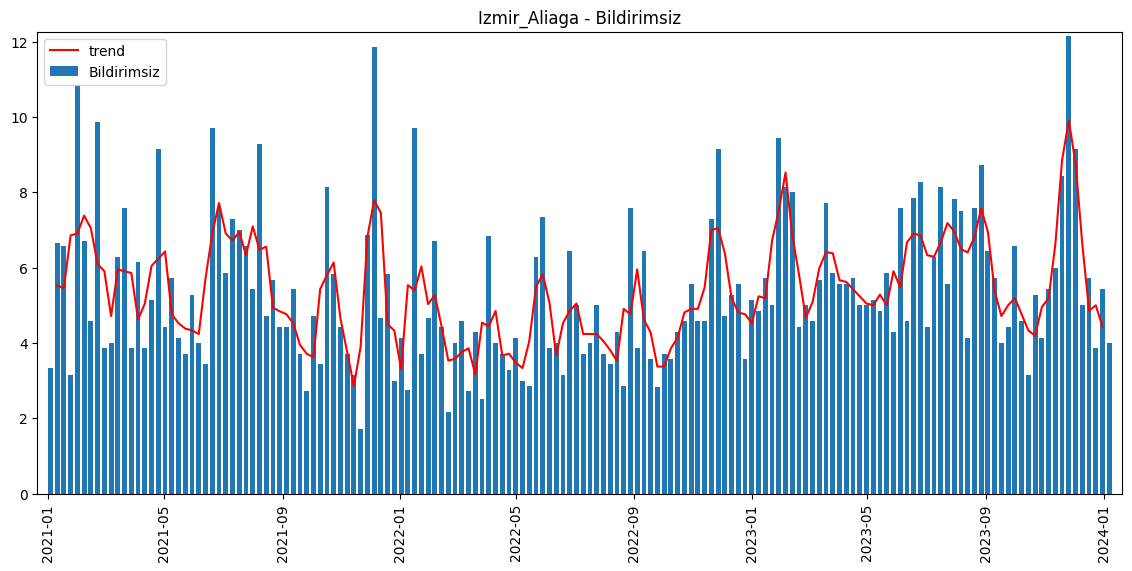

In [22]:
# 7-) her ilce icin grafikleri olustur. (trend, tahmin gibi parametreleri de göster)

plt.figure(figsize=(14,6))
plt.bar(merged_all_week["izmir-aliaga"].index,merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=5, label="Bildirimsiz")
plt.margins(0.01)
plt.title("Izmir_Aliaga - Bildirimsiz")
plt.xticks(rotation=90)
ayristirma2 = sm(merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], model="mul", period=3)
"""
analiz = pd.concat([
    ayristirma2.observed,
    ayristirma2.trend,
    ayristirma2.seasonal,
    ayristirma2.observed/ayristirma2.seasonal # orijinal veri / S = T * E, regr. da üzerine tahmin yapılacak sey
], axis=1)
analiz.columns = ["Orijinal Gözlem", "Trend", "Mevsimsellik", "Mevsimsellik Düzeltme"]

indeks = np.arange(1,len(df.index) + 1)


X = sa.add_constant(indeks)
model = sa.OLS(analiz["Mevsimsellik Düzeltme"], X)
sonuc = model.fit()

y = pd.date_range(analiz.index[-1] + pd.DateOffset(month=3), periods=4,freq="M") # 4 tane ekstra ay ekle

yeni_satirlar = pd.DataFrame(index=y)
analiz = pd.concat([analiz, yeni_satirlar])

# not: bu degerleri ayarla
mev = [
    1.038656,
    0.973940,
    0.987404,
    1.038656
]

nan_indices = analiz.index[analiz['Mevsimsellik'].isna()]
for i, index in enumerate(nan_indices):
    if i < len(mev):
        analiz.at[index, 'Mevsimsellik'] = mev[i]
print(analiz["Mevsimsellik"])

girdi = np.arange(1,len(df.index) + 5)
regmodel = sonuc.predict(sa.add_constant(girdi))

analiz["Tahmin"] = analiz["Mevsimsellik"] * regmodel


plt.plot(analiz["Mevsimsellik Düzeltme"], label="Mevsimsellik Düzeltme")
plt.plot(analiz["Orijinal Gözlem"], label="Orijinal Gözlem")
plt.plot(analiz["Tahmin"], label="Tahmin")
"""
plt.plot(ayristirma2.trend, color="red", label="trend")
plt.legend()
plt.show()

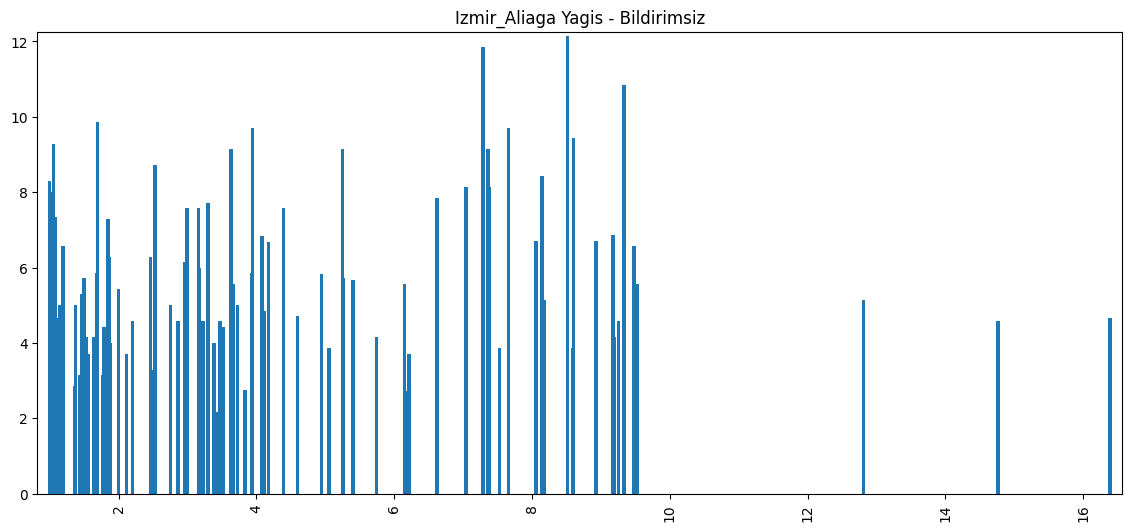

same as here


In [23]:
# 8-) farkli tur degiskenler arasi iliskeler grafiklenmeli (denenecek)

plt.figure(figsize=(14,6))
plt.bar(merged_all_week["izmir-aliaga"]["Yagis"],merged_all_week["izmir-aliaga"]["Bildirimsiz_sum"], width=0.05, label="Bildirimsiz")
plt.margins(0.01)
plt.title("Izmir_Aliaga Yagis - Bildirimsiz")
plt.xticks(rotation=90)
plt.show()
print("same as here")

In [ ]:
test = pd.read_csv("./test.csv", low_memory=False)
# birlestirme islemi weather holiday

MAKINE OGRENMESI

In [ ]:
#merged_all[]
df = merged_all['izmir-konak'] #ml icin hazir csv dosyasi
df_test = test #test csv birlestirilmis hazir dosyasi
features = ['bildirimli_sum','sicaklik vs'] #kalan ozellikler de yazilmali
output_var = df['bildirimsiz_sum']
target = 'bildirimsiz_sum'
ilceler = []

dict = {}
for label, group in train.groupby("ilce"):
    dict[label] = group
ilceler = list(dict.keys())

In [ ]:
# ilcelerin numerizasyonu -------- NEW olmasa da direkt sayilar olsa daha iyi olabilir
columns_tonumerate = ['ilce','BAYRAM_FLAG','vs vs.']
for column in columns_tonumerate:
    encoder = LabelEncoder()
    encode = encoder.fit_transform(df[column])
    df[column + '_NEW'] = encode #buraya _NEW eklemeli miyim tekrar bakmak gerek
    df.drop(columns=[column], inplace=True)

# csv dosyasi numerizasyon - sadece numarizasyon degil ayni zamanda weather ile birlestirme de yapilmali!!
for column in columns_tonumerate:
    encoder = LabelEncoder()
    encode = encoder.fit_transform(df_test[column])
    df_test[column + '_NEW'] = encode
    df_test.drop(columns=[column], inplace=True)

#Scaling
scaler = MinMaxScaler()
feature_transform = scaler.fit_transform(df[features])
feature_transform = pd.DataFrame(columns=features, data=feature_transform, index=df.index)
feature_transform.head()


# test.csv numerizasyonu da gerekiyor ayni sekilde

In [ ]:
# x-y test-train elde edimi
x = df[features]
y = output_var # = df["target_var"]
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=53, shuffle=True)

#Splitting to Training set and Test set --- burasi timeseries icin split
timesplit = TimeSeriesSplit(n_splits=15)
for train_index, test_index in timesplit.split(feature_transform):
        X_tr, X_te = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_tr, y_te = output_var[:len(train_index)].values.ravel(), output_var[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [ ]:
# LSTM

#Process the data for LSTM
trainX = np.array(X_tr)
testX = np.array(X_te)
X_tr = trainX.reshape(X_tr.shape[0], 1, X_tr.shape[1])
X_te = testX.reshape(X_te.shape[0], 1, X_te.shape[1])

#Building the LSTM Model
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(1, trainX.shape[1]), activation='relu', return_sequences=False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

#Model Training
history=lstm.fit(X_tr, y_tr, epochs=100, batch_size=8, verbose=1, shuffle=False)

#LSTM Prediction
y_pr= lstm.predict(X_te)

# Predicted vs True Adj Close Value – LSTM  --burasi copy paste
plt.plot(y_te, label='True Value')
plt.plot(y_pr, label='LSTM Value')
plt.title("Prediction by LSTM")
plt.xlabel('Time Scale')
plt.ylabel('Scaled USD')
plt.legend()
plt.show()

# test_pred = lstm.predict(gercek test)
# csv ye yazdir vs vs

In [ ]:
# KNN

X = df[features].values()
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=53, shuffle=True)

k=17
neigh = KNeighborsClassifier(n_neighbors=k, weights='distance')
neigh.fit(X_train, y_train)

y_hat = neigh.predict(X_test)

test_accuracy = neigh.score(X_test, y_test)

print("Test accuracy with class weights:", test_accuracy)
print("egitim verisi dogrulugu ", metrics.accuracy_score(y_train,neigh.predict(X_train)))
print("test verisi dogrulugu ", metrics.accuracy_score(y_test,y_hat))

# test tahmin
y_hat = neigh.predict(isteburayatestdosyasi)
submission = pd.read_csv("sample_submission.csv", low_memory=False)
submission.iloc[:, 1] = y_hat
# submission.to_csv("knnsubmission.csv", index=False)

# optimal k degeri

# # Define the range of k values to try
# k_values = range(1, 21)

# # Perform cross-validation for each value of k
# cv_scores = []
# for k in k_values:
#     neigh = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(neigh, X_train, y_train, cv=5)
#     cv_scores.append(scores.mean())

# # Find the optimal value of k with the highest cross-validation score
# optimal_k = k_values[cv_scores.index(max(cv_scores))]
# print("Optimal k:", optimal_k)

# # Train the model with the optimal k value
# neigh = KNeighborsClassifier(n_neighbors=optimal_k).fit(X_train, y_train)
# test_accuracy = neigh.score(X_test, y_test)
# print("Test accuracy with optimal k:", test_accuracy)
# print("")

In [ ]:
# NN
# alinan kaynakta goruntu isleme icin kullaniliyordu bazi uyusmazliklar olabilir
# Cast the records into float values 
# x_train = x_train.astype('float32') 
# x_test = x_test.astype('float32') 

print("Feature matrix:", x_train.shape) 
print("Target matrix:", x_test.shape) 
print("Feature matrix:", y_train.shape) 
print("Target matrix:", y_test.shape)  
model = Sequential([ 
    Flatten(input_shape=(x_train.shape)), 
    
    # dense layer 1 
    Dense(256, activation='sigmoid'),   
    
    # dense layer 2 
    Dense(128, activation='sigmoid'),  
    
    # output layer 
    Dense(10, activation='sigmoid'),   
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy']) 

model.fit(x_train, y_train, epochs=10,  
          batch_size=2000,  
          validation_split=0.2)

results = model.evaluate(x_test,  y_test, verbose = 0) 
print('test loss, test acc:', results)

Sequential() specifies that the network is a linear stack of layers

model.add() adds the hidden layer.

Dense means that neurons between layers are fully connected

input_dim defines the number of features in the training dataset

activation defines the activation function

loss selects the cost function

optimizer selects the learning algorithm

metrics selects the performance metrics to be saved for further analysis

model.fit() initialize the training

In [ ]:
# NN2

X = df[features] #features
y = df['target_var'] #expected values

model = Sequential()
model.add(Dense(16, input_dim=2, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['binary_accuracy', 'mean_squared_error'])

history = model.fit(X, y, epochs=3000, verbose=0)

y_pred = model.predict(X).round()
num_correct_predictions = (y_pred == y).sum()
accuracy = (num_correct_predictions / y.shape[0]) * 100
print('Multi-layer perceptron accuracy: %.2f%%' % accuracy)